In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 11.4  t-distribution Stochastic Neighbor Embedding (t-SNE)

t-SNE is an algorithm for visualizing high-dimensional data by projecting it into a low-dimensional space. t-SNE is the current state of the art for dimensionality reduction algorithms.

Here's how t-SNE works:

### 11.4.1 - t-SNE Step by Step

**Similarity Matrix**

By using a **Gaussian distribution**, t-SNE starts by converting the high-dimensional Euclidean distances between datapoints into conditional probabilities that represent **similarities**.

The similarity of datapoint $x_j$ to datapoint $x_i$ is 

$$
p_{j|i} = C \exp\left(-\|x_i - x_j\|_2^2/2\sigma^2_i\right), \qquad \mbox{where} \qquad C = \frac{1}{\sum_{k\neq i} \exp\left(-\|x_i - x_k\|_2^2/2\sigma^2_i\right)}.
$$

The constant $C$ is just a normalization constant (to make the probabilities add up to one).
For nearby datapoints, $p_{j|i}$ is relatively high, whereas for widely separated datapoints, $p_{j|i}$ will be almost infinitesimal.
The similarity $p_{i|i}$ is defined to be zero.

**Perplexity**

The parameter $σ_i$ is the variance of the Gaussian that is centered on datapoint $x_i$.
For each datapoint $x_i$, the algorithm has to select $\sigma_i$.
The method that t-SNE uses for determining the value of $\sigma_i$ is based on **perplexity**.

The perplexity is defined as

$$
\mathrm{perplexity} = \exp\left(\sum_j -p_{j|i}\log (p_{j|i}) \right).
$$

Roughly speaking, the perplexity can be interpreted as a measure of the effective number of neighbors of datapoint $x_i$ (i.e., points that are within a distance $2\sigma_i$ from $x_i$). 
t-SNE selects the value of $\sigma_i$ that produces a fixed perplexity that is specified by the user.

Text(0.5, 1.0, 'Number of neighbors = 15')

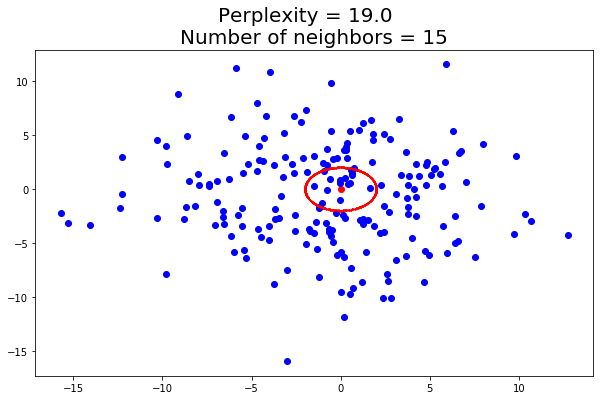

In [12]:
'perplexity example'
sigma = 1

# xi point
xi = np.array([0,0]) 
# xj points
m = 200
xj = 5*np.random.randn(m,2)

# compute distances from xj points to xi
distances = np.array([np.linalg.norm(xi-xj[j]) for j in range(m)])
# compute similarities between xj points and xi
p = np.exp(-np.square(distances)/(2*(sigma**2)))
p = p/np.sum(p)
# compute perplexity
perplexity = np.exp(np.sum(-p*np.log(p)))

# compute number of neighbors of xi (i.e., points that are within a 2*sigma distance from xi)
n_neighbors = np.sum(distances<2*sigma) 

# plot points
plt.figure(figsize=(10,6))
plt.plot(xi[0],xi[1],'ro')
plt.plot(xj[:,0],xj[:,1],'bo')

# plot a circle centered at xi with radius 2*sigma
angles = 2*np.pi*np.random.randn(2000)
xc = 2*sigma*np.sin(angles)
yc = 2*sigma*np.cos(angles)
plt.plot(xc,yc,'ro',markersize=0.5,)
plt.suptitle('Perplexity = '+str(np.round(perplexity)),fontsize=20)
plt.title('Number of neighbors = '+str(n_neighbors),fontsize=20)

In [3]:
def compute_perplexity(D, beta=1.0):
    """
        Given the distances D, it computes the logarithm of 
        the perplexity, and the P-column (similarities) for a specific value of 
        beta = 1/2*sigma**2
    """

    # Compute P-column and corresponding log-perplexity
    P_column = np.exp(-D * beta)
    sumP = np.sum(P_column)
    log_perplexity = np.log(sumP) + beta * np.sum(D * P_column) / sumP
    P_column = P_column / sumP
    return log_perplexity, P_column

**Choosing the Sigmas: Binary Search**

The perplexity is an increasing function of $\sigma_i$ (i.e., the perplexity increases as $\sigma_i$ increases). 
t-SNE performs a **binary search** for the value of $\sigma_i$ that produces $p_{j|i}$ values with a **fixed perplexity that is specified by the user**.
The basic reason is that in t-SNE, we want the number of neighbors to be roughly the same for all points to prevent any single point from wielding a disproportionate influence. This means that we want $\sigma_i$  to be small for points in densely populated areas and large for sparse areas

**Remark**: binary search (aka bisection method) works by repeatedly dividing in half the interval that could contain the desired value of $\sigma_i$.

In [13]:
def binary_search(D, tol, perplexity):
    '''
    Given the distances D, it performs a binary search
    to find the value of beta = 1/2*sigma**2 that produces the specified perplexity
    '''
    
    beta = 1.0 # initial beta
    logU = np.log(perplexity) # log of the specified perplexity
    
    # interval range
    betamin = -np.inf
    betamax = np.inf
    
    thisPerplexity, thisP_column = compute_perplexity(D,beta)
    
    # Evaluate whether the perplexity is within tolerance
    Perplexity_diff = thisPerplexity - logU
    tries = 0
    while np.abs(Perplexity_diff) > tol and tries < 50: 
        if Perplexity_diff > 0: # decrease beta (i.e., increase sigma)
            betamin = beta
            if betamax == np.inf:
                beta = beta * 2.
            else:
                beta = (beta + betamax) / 2.
        else: # increase beta (i.e., decrease sigma)
            betamax = beta
            if betamin ==  -np.inf:
                beta = beta / 2.
            else:
                beta = (beta + betamin) / 2.

        # Recompute the values
        thisPerplexity, thisP_column = compute_perplexity(D,beta)
        Perplexity_diff = thisPerplexity - logU
        tries += 1
    return beta, thisPerplexity, thisP_column

Text(0.5, 1.0, 'Number of neighbors = 76')

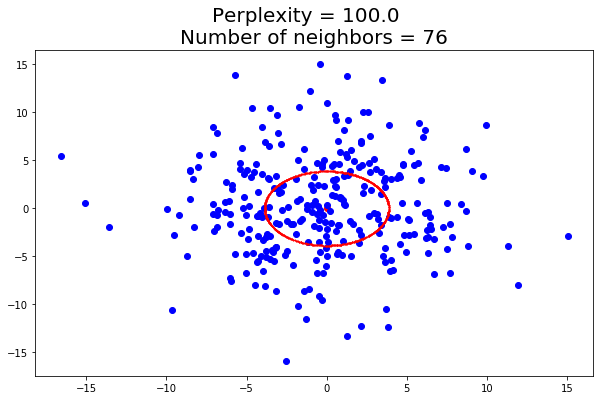

In [42]:
'test the binary_search function'
# xi point 
xi = np.array([0,0]) 
# xj points
m = 300
xj = 5*np.random.randn(m,2)

# compute distances from xj points to xi
distances = np.array([np.linalg.norm(xi-xj[j]) for j in range(m)])

# desired perplexity
desired_perplexity = 100

# find the value of sigma that produces the specified perplexity
beta, thisPerplexity, thisP_column = binary_search(D = distances,
                     tol = 1e-5, 
                     perplexity = desired_perplexity)
sigma = np.square(1/(beta)) # compute sigma from beta
# check that the perplexity is equal to the specified perplexity
perplexity = np.exp(thisPerplexity) # our function computes the log of the perplexity

# compute number of neighbors
n_neighbors = np.sum(distances<2*sigma) 

# plot points
plt.figure(figsize=(10,6))
plt.plot(xi[0],xi[1],'ro')
plt.plot(xj[:,0],xj[:,1],'bo')

# plot a circle centered at xi with radius 2*sigma
angles = 2*np.pi*np.random.randn(2000)
xc = 2*sigma*np.sin(angles)
yc = 2*sigma*np.cos(angles)
plt.plot(xc,yc,'ro',markersize=0.5,)
plt.suptitle('Perplexity = '+str(np.round(perplexity)),fontsize=20)
plt.title('Number of neighbors = '+str(n_neighbors),fontsize=20)

**Recreating the Original Similarities**

Next, t-SNE converts the high-dimensional dataset $X = \{x_1,x_2,\ldots,x_m\}$ into two or three-dimensional data $Y=\{y_1,y_2,\ldots,y_m\}$ that can be displayed in a scatterplot.
t-SNE uses the **Student t-distribution** to recreate the similarities $p_{j|i}$ in low-dimensional space.

 The similarity of datapoint $y_j$ to datapoint $y_i$ in the corresponding low-dimensional space is
 
 $$
 q_{j|i} = C (1+\|y_i-y_j\|_2^2)^{-1} \qquad \mbox{where} \qquad C = \sum_{k}\sum_{\ell\neq k}(1+\|y_k-y_\ell\|_2^2)^{-1},
 $$
 and where we set $q_{i|i}=0$.

**Remark**: The natural choice of using a Gaussian distribution

$$
q_{j|i} = C \exp\left(-\|y_i - y_j\|_2^2/2\right)
$$

does not work well in practice. 
All the points get "squashed" in the lower dimension.
This was known as the crowding problem.
The Student t distribution prevents crowding.

 The Student t-distribution is very much like the Gaussian, except that it has heavy tails, meaning that outliers have a much higher probability of occurrence, as shown in the graph below.

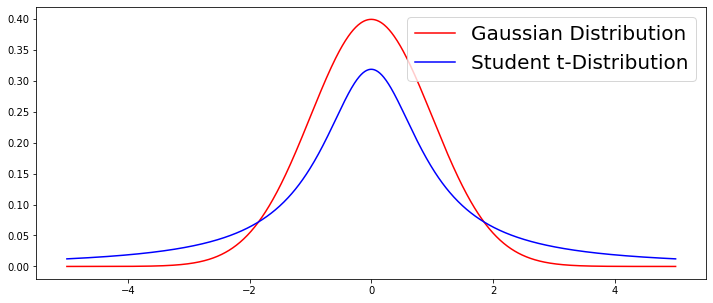

In [53]:
'Gaussian vs Student'
xplot = np.linspace(-5,5,1000)
# Guassian Distribution
yG = np.exp(-(xplot**2)/2)/np.sqrt(2*np.pi)
# Student t Distribution
yS = 1/(1+(xplot**2))/np.pi

# Plot the two distributions
plt.figure(figsize=(12,5))
plt.plot(xplot,yG,'r-', label = 'Gaussian Distribution')
plt.plot(xplot,yS,'b-', label = 'Student t-Distribution')
plt.legend(fontsize=20)

**Cost Function**

 t-SNE then tries to minimize the difference between the similarities $p_{j|i}$ and $q_{j|i}$ in higher-dimensional and lower-dimensional space. 
 To do this, t-SNE minimizes the cost function
 
 $$
 \mathrm{cost} = \sum_{i=1}^m\sum_{j=1}^m p_{ij}\log\frac{p_{ij}}{q_{ij}} \qquad \mbox{where} \qquad p_{ij} = \frac{p_{j|i}+p_{i|j}}{2m} \qquad \mbox{and} \qquad q_{ij} =  q_{j|i} 
 $$

Two comments on the cost function:
1. the cost function is equal to zero only when  $p_{ij}=q_{ij}$, for $i,j=1,2,\ldots,m$.
2. Stochastic Neighbor Embedding (SNE), the ancestor of t-SNE, minimizes the cost function

 $$
 \mathrm{cost} = \sum_{i=1}^m\sum_{j=1}^m p_{j|i}\log\frac{p_{j|i}}{q_{j|i}}
 $$
 
 This cost function seems more natural, but it does not work well when the dataset contains outliers.
 This is why $p_{j|i}$ was replaced with $p_{ij}=\frac{p_{j|i}+p_{i|j}}{2m}$ in the cost function.

**The Gradient**

The gradient of the cost function is surprisingly simple

$$
\frac{\partial}{\partial y_i} \mathrm{cost} = 4 \sum_{j=1}^m (p_{ij}- q_{ji})(y_i-y_j)(1+\|y_i-y_j\|_2^2)^{-1}
$$

**Minimizing the Cost Function**

The minimization method is mostly just simple **gradient descent with momentum**. There are, however, several tricks that make the convergence faster.

**Trick 1 - PCA:** t-SNE is faster if we start by using PCA to reduce the dimensionality of the dataset. 

**Trick 2 - Early exaggeration:** Early exaggeration is a trick where all the $p_{ij}$ are multiplied and "exaggerated" at the early stages of optimization. The effect of this is to force the values of $q_{ij}$  to become more focused on larger $ p_{ij} $ (i.e. closer points), making early clusters more tightly knit, allowing them to "move around" more easily without getting in each others' ways.

**Trick 3 - Changing the learning rate:** If the gradient at iteration $i$ and the gradient descent update at iteration $i-1$ have different signs (positive-negative or negative-positive), it indicates that GD is probably going in the right direction (towards a minimum). In this case, we slightly increase the learning rate. 
Otherwise, we slightly decrease it.

### 11.4.2 t-SNE implementation

In [164]:
def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, max_iter = 1000):
    """
        Runs t-SNE on the dataset to reduce its
        dimensionality to no_dims dimensions. 
        
    Parameters:
    ----------
    
    no_dims (default=2): Dimension of the embedded space
    
    initial_dims (default=50): dimension of the initial PCA dimensionality reduction
    
    perplexity (default=30): The perplexity is related to the number of nearest neighbors. 
                             Consider selecting a value between 5 and 50.
    
    eta (default=500): learning rate
    
    max_iter (default=1000): Gradient Descent iteration
    """
    
    # useful functions 
    from scipy.spatial import distance
    from numpy.linalg import eig
    def pca(X, initial_dims=50):
        """
            Runs PCA on the mxn array X in order to reduce its dimensionality to
            initial_dims dimensions.
        """
        print("Preprocessing the data using PCA...")
        m, n = X.shape
        X = X - np.mean(X,axis=0) # center X
        _,_,v = np.linalg.svd(X,full_matrices=False)
        Y = X@v[:initial_dims].T
        return Y
    def compute_perplexity(D, beta=1):
        """
            Compute the log-perplexity and the P-column for a specific value of the
            beta = 1/2*sigma**2
        """
        # Compute P-column and corresponding perplexity
        P = np.exp(-D*beta)
        sumP = np.sum(P)
        perplexity = np.log(sumP) + beta*np.sum(D*P)/sumP
        P = P/sumP
        return perplexity, P
    def x2p(X, tol=1e-5, perplexity=30.0):
        """
            Performs a binary search to get P-values in such a way that each
            conditional Gaussian has the same perplexity.
        """
        m,n = X.shape
        # compute all pairwise distances
        D = np.square(distance.squareform(distance.pdist(X)))
        # initialize variables
        P = np.zeros((m, m))
        beta = np.ones((m, 1))
        logU = np.log(perplexity)
        # Compute P matrix
        for i in range(m):
            # interval range
            betamin = -np.inf
            betamax = np.inf
            # Print progress
            if i % 500 == 0:
                print("Computing P-values for point %d of %d..." % (i, m))
                
            # Compute the similarities and perplexity
            idx = np.concatenate((range(0,i),range(i+1,m))).astype('int')
            Di = D[idx,i] 
            Perplexity,P_column = compute_perplexity(Di, beta[i])
            
            # Perform a binary search
            PerplexityDiff = Perplexity - logU
            tries = 0
            while np.abs(PerplexityDiff) > tol and tries < 50:
                if PerplexityDiff > 0:
                    betamin = beta[i].copy()
                    if betamax == np.inf: 
                        beta[i] = beta[i] * 2.
                    else:
                        beta[i] = (beta[i] + betamax) / 2.
                else:
                    betamax = beta[i].copy()
                    if betamin == -np.inf: 
                        beta[i] = beta[i] / 2.
                    else:
                        beta[i] = (beta[i] + betamin) / 2.               
                # Recompute perplexiy
                Perplexity, P_column = compute_perplexity(Di, beta[i])
                PerplexityDiff = Perplexity - logU
                tries += 1
            # Set the final column of P
            P[idx,i] = P_column
        # Return final P-matrix
        print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
        return P
    
    #################### MAIN FUNCTION ##################
    m,n = X.shape
    # Perform PCA
    X = pca(X, initial_dims)
    # Gradient Descent with Momentum parameters
    initial_momentum = 0.5
    final_momentum = 0.8
    min_gain = 0.01 
    # Initialize variables
    Y = np.random.randn(m, no_dims)
    dY = np.zeros((m, no_dims)) # gradient
    iY = np.zeros((m, no_dims)) # gradient on previous iteration
    gains = np.ones((m, no_dims)) 
    
    # Compute P matrix
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4
    P = np.maximum(P, 1e-12)
    
    # Gradient Descent
    for iter in range(max_iter):
        # Compute pairwise affinities qij
        DY = np.square(distance.squareform(distance.pdist(Y)))
        num = 1/(1+DY)
        np.fill_diagonal(num, 0) #set diagonal entries of num to 0
        Q = num/np.sum(num) # normalize 
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PminusQ = P - Q     
        for i in range(m):
            dY[i] = 4*(PminusQ[:, i] * num[:, i])@(Y[i]-Y)
        
        # Momentum coefficient
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        # Increase or decrease learning rate    
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain 
        
        # Update
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.mean(Y,axis=0) # center the dataset


        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            cost = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, cost))
        # Stop early exaggeration    
        if iter == 100: 
            P = P / 4.
    # Return solution 
    return Y

### 11.4.3 Examples: the MNIST Dataset

We'll use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. 

In [160]:
'Obtain the MNist dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
X,y=mnist['data'],mnist['target']

We'll use a small subset of the MNIST dataset

In [161]:
X = X[:3000]
y = y[:3000]
y = y.astype(np.uint8)

Let's normalize the dataset.

In [162]:
X = X/np.max(np.abs(X))

Let's run t-sne on the MNist dataset

In [165]:
Y = tsne(X)

Preprocessing the data using PCA...
Computing P-values for point 0 of 3000...
Computing P-values for point 500 of 3000...
Computing P-values for point 1000 of 3000...
Computing P-values for point 1500 of 3000...
Computing P-values for point 2000 of 3000...
Computing P-values for point 2500 of 3000...
Mean value of sigma: 2.175616
Iteration 100: error is 16.454595
Iteration 200: error is 1.261813
Iteration 300: error is 1.155744
Iteration 400: error is 1.118462
Iteration 500: error is 1.099902
Iteration 600: error is 1.089024
Iteration 700: error is 1.081975
Iteration 800: error is 1.076843
Iteration 900: error is 1.073188
Iteration 1000: error is 1.070435


Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit:

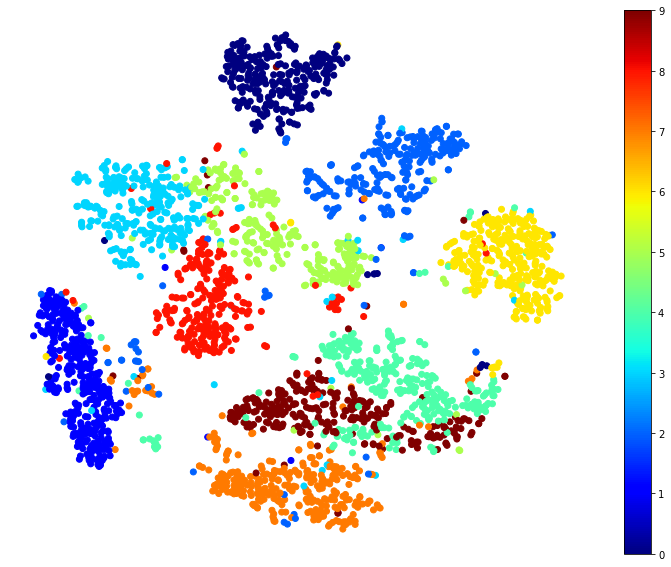

In [166]:
plt.figure(figsize=(13,10))
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).